## Сегодня мы будем заниматься нейросетями для работы с картинками.
** Делать все будем на tensorflow, можете пока его поставить: https://www.tensorflow.org/install/ **

* `pip install tensorflow` -- **cpu-only** version for Linux & Mac OSX
* if you want GPU support try -- `pip install tensorflow-gpu`

In [130]:
# Для ленивых (ubuntu).
# !conda create -n tensorflow pip python=3.3,
# !source activate tensorflow
# !pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-1.5.0-cp34-cp34m-linux_x86_64.whl


<img src="img/act.png" width="800">

## Слои свертки извлекают из картинки фичи - численные представления каких то признаков. В дальнейшем на основе этих признаков можно делать классификацию картинок.

## Рассмотрим популярные архитектуры. 

### VGG (стандартная архитектура)

<img src="img/vgg.png" width="600">

### ResNet (Shortcut + Batch Normalization)
 
<img src="img/resnet.png" width="800">
 
### GoogleNet (Много раз предсказываем классы на разных уровнях сети)

 
<img src="img/gln.png" width="800">


## Чем глубже слой тем более высокоуровневые признаки он детектирует

<img src="img/feat.png" width="800">

## На практике гораздо проще дообучать уже обученные сети (Fine-Tuning)

<img src="img/ft.jpg" width="600">

## Как можно заметить, они и правда глубокие.

## Dark Magic 

<img src="img/dm.png" width="600">

In [68]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
%matplotlib inline

** Поиграемся немного с библиотекой. ** 

In [10]:
tf.__version__

'1.3.0'

## Функции делаются аналогично numpy. Однако стоит помнить, что мы задаем граф вычислений, и то, что мы пишем, будет вычисляться только во время запуска сессии.

## Placeholder это просто константа заданного размера.

In [14]:
N = tf.placeholder('int64', name="input_to_your_function")
# Возведение числа N в квадрат.
result_0 = tf.pow(N,2)
# Подсчет суммы квадратов чисел до N.
result_1 = tf.reduce_sum((tf.range(N)**2))

In [15]:
result_0

<tf.Tensor 'Pow:0' shape=<unknown> dtype=int64>

# How does it work?
1. define placeholders where you'll send inputs;
2. make symbolic graph: a recipe for mathematical transformation of those placeholders;
3. compute outputs of your graph with particular values for each placeholder
  * output.eval({placeholder:value}) 
  * s.run(output, {placeholder:value})

* So far there are two main entities: "placeholder" and "transformation"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats of booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * tf.reduce_sum(tf.arange(N)\**2) are 3 sequential transformations of placeholder N
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * np.mean -> tf.reduce_mean
   * np.arange -> tf.range
   * np.cumsum -> tf.cumsum
   * If if you can't find the op you need, see the [docs](https://www.tensorflow.org/api_docs/python).

## Все значения стартовых переменных передаются в сессию в виде dict. 

In [23]:
sess = tf.Session()

In [25]:
print(sess.run(result_0, {N:100}))

10000


In [26]:
print(sess.run(result_1, {N:100}))

328350


In [28]:
# Пример посложнее.
x = tf.placeholder(dtype='float32', shape=(10,))
y = tf.placeholder(dtype='float32', shape=(10,))

In [29]:
func = 100 * tf.multiply(y,x)

In [35]:
dummy = np.arange(10).astype('float32')
print(func.eval({x:dummy, y:dummy}, session=sess))

[    0.   100.   400.   900.  1600.  2500.  3600.  4900.  6400.  8100.]


# Так же можно считать градиенты.

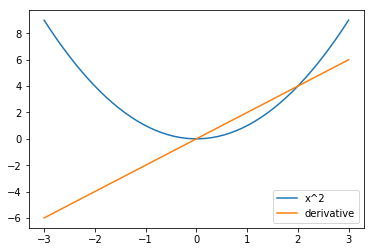

In [41]:

my_scalar = tf.placeholder('float32')
scalar_squared = my_scalar**2

derivative = tf.gradients(scalar_squared, my_scalar)[0]

x = np.linspace(-3,3)
x_squared, x_squared_der = sess.run([scalar_squared,derivative],
                                 {my_scalar:x})
plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend();

### Таким образом можно автоматически считать градиенты даже у очень противных функций. Важно понимать, что это не численное дифференцирование, внутри tensorflow написаны формулы для производных простых опираций, а далее он идет по вершинам графа вычислений и расписывает производную сложной функции.

# variables

The inputs and transformations have no value outside function call. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 

In [45]:
v_1 = tf.Variable(initial_value=np.ones(5))

In [46]:
#initialize variable(s) with initial values
sess.run(tf.global_variables_initializer())

#evaluating shared variable (outside symbolicd graph)
print("initial value", sess.run(v_1))

# within symbolic graph you use them just as any other inout or transformation, not "get value" needed

initial value [ 1.  1.  1.  1.  1.]


## Теперь сами напишем логистическую регрессию на tensorflow.

In [48]:
from sklearn.datasets import load_digits
mnist = load_digits(2)
X,y = mnist.data, mnist.target

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:


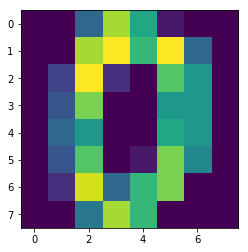

In [53]:
plt.imshow(X[0].reshape([8,8]))

In [77]:
# переменные и входы
weights = tf.Variable(np.zeros(shape=(64,1), dtype='float32'))
input_X = tf.placeholder('float32', shape=(None,64))
input_y = tf.placeholder('float32', shape=(None,1))

In [78]:
predicted_y = (1. + tf.exp(-1. * tf.matmul(input_X, weights))) ** -1.
# Подумайте, зачем перед loss написан epsilon.
epsilon = 0.0004
loss = -1. * (tf.reduce_sum( tf.multiply(input_y,tf.log( epsilon + predicted_y)) 
                            + tf.multiply((1 - input_y), tf.log(1 + epsilon - predicted_y)) ))

### Вместо того, чтобы самим писать градиентный спуск, воспользуемся оптимизатором.

In [79]:
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss, var_list=weights)

In [80]:
# <compile function that takes X and y, returns log loss and updates weights>
def train_function(X, y,s=sess):    
    X = X.reshape((batch_size,64))
    y = y.reshape((batch_size,1))
    s.run(optimizer, {input_X:X, input_y:y})
    log_loss = s.run(loss, {input_X:X, input_y:y})
    return log_loss
    
predict_function = lambda X: sess.run(tf.round(predicted_y), {input_X:X})

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [82]:
sess.run(tf.global_variables_initializer())
batch_size=10

loss at iter 0:2.4281
train auc: 0.832142857143
test auc: 0.845238095238
loss at iter 1:5.4597
train auc: 0.580769230769
test auc: 0.5625
loss at iter 2:0.8648
train auc: 0.775
test auc: 0.785714285714
loss at iter 3:-0.0040
train auc: 0.989285714286
test auc: 0.952380952381
loss at iter 4:0.0058
train auc: 0.989285714286
test auc: 0.952380952381
resulting weights:


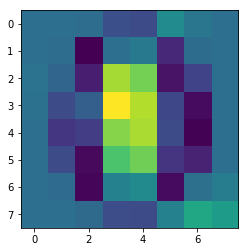

In [86]:
sess.run(tf.global_variables_initializer())
for i in range(5):
    rand_list = random.sample(range(0, X_train.shape[0]), batch_size)
    X_sample = X_train[rand_list]
    y_sample = y_train[rand_list]
    loss_i = train_function(X_sample, y_sample)
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train auc:",roc_auc_score(y_train, predict_function(X_train)))
    print("test auc:",roc_auc_score(y_test, predict_function(X_test)))

# Посмотрим, на какие места в картинке смотрит наш классификатор.  
print ("resulting weights:")
plt.imshow(weights.eval(session=sess).reshape([8,8]))

## Теперь вспомним, что мы тут все-таки занимаемся нейросетями.

** Более подробно здесь: https://www.tensorflow.org/tutorials/layers **


1) Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions), with ReLU activation function

2) Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)

3) Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function

4) Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2

5) Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)

6) Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9). 

In [87]:
from mnist import load_dataset

In [94]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [98]:
# Load training and eval data
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [102]:
print('Размер обучающей выборки', train_data.shape, ', target размера', train_labels.shape)

Размер обучающей выборки (55000, 784) , target размера (55000,)


In [110]:
visible = train_data.reshape((train_data.shape[0], 28, 28))

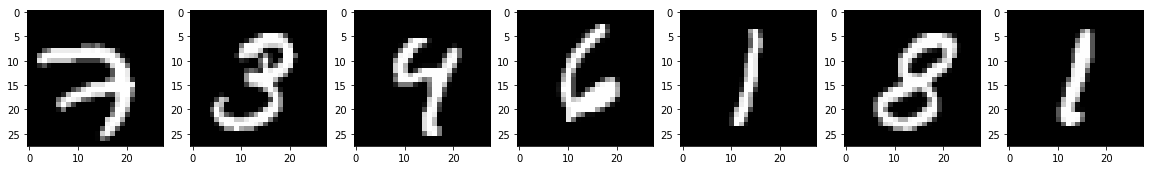

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 20))

for i, ax in enumerate(axes):
    ax.imshow(visible[i], cmap='gray')

In [124]:
# Построим модель.
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [125]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_convnet_model', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [127]:
%%time
# !!! Считается долго.
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 30.5 µs
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-1003
INFO:tensorflow:Saving checkpoints for 1004 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 1.89851, step = 1004
INFO:tensorflow:global_step/sec: 12.9139
INFO:tensorflow:loss = 1.65035, step = 1104 (7.748 sec)
INFO:tensorflow:global_step/sec: 12.9727
INFO:tensorflow:loss = 1.62144, step = 1204 (7.707 sec)
INFO:tensorflow:global_step/sec: 12.7631
INFO:tensorflow:loss = 1.35541, step = 1304 (7.834 sec)
INFO:tensorflow:global_step/sec: 12.2649
INFO:tensorflow:loss = 1.23108, step = 1404 (8.153 sec)
INFO:tensorflow:global_step/sec: 11.7591
INFO:tensorflow:loss = 1.12323, step = 1504 (8.504 sec)
INFO:tensorflow:global_step/sec: 12.5315
INFO:tensorflow:loss = 0.969237, step = 1604 (7.980 sec)
INFO:tensorflow:global_step/sec: 12.9438
INFO:tensorflow:loss = 0.992188, step = 1704 (7.726 sec

INFO:tensorflow:global_step/sec: 12.7952
INFO:tensorflow:loss = 0.28596, step = 9104 (7.814 sec)
INFO:tensorflow:global_step/sec: 12.7091
INFO:tensorflow:loss = 0.207015, step = 9204 (7.871 sec)
INFO:tensorflow:global_step/sec: 12.7865
INFO:tensorflow:loss = 0.0907497, step = 9304 (7.818 sec)
INFO:tensorflow:global_step/sec: 12.9872
INFO:tensorflow:loss = 0.189908, step = 9404 (7.700 sec)
INFO:tensorflow:global_step/sec: 12.4411
INFO:tensorflow:loss = 0.229828, step = 9504 (8.038 sec)
INFO:tensorflow:global_step/sec: 12.6925
INFO:tensorflow:loss = 0.216801, step = 9604 (7.881 sec)
INFO:tensorflow:global_step/sec: 11.8007
INFO:tensorflow:loss = 0.221563, step = 9704 (8.475 sec)
INFO:tensorflow:global_step/sec: 12.487
INFO:tensorflow:loss = 0.199536, step = 9804 (8.006 sec)
INFO:tensorflow:global_step/sec: 12.4682
INFO:tensorflow:loss = 0.0977587, step = 9904 (8.022 sec)
INFO:tensorflow:global_step/sec: 12.5917
INFO:tensorflow:loss = 0.210455, step = 10004 (7.940 sec)
INFO:tensorflow:glo

INFO:tensorflow:loss = 0.112831, step = 17304 (8.001 sec)
INFO:tensorflow:global_step/sec: 12.412
INFO:tensorflow:loss = 0.0434363, step = 17404 (8.059 sec)
INFO:tensorflow:global_step/sec: 12.4618
INFO:tensorflow:loss = 0.10587, step = 17504 (8.023 sec)
INFO:tensorflow:global_step/sec: 11.1179
INFO:tensorflow:loss = 0.135308, step = 17604 (8.994 sec)
INFO:tensorflow:global_step/sec: 11.4086
INFO:tensorflow:loss = 0.153014, step = 17704 (8.766 sec)
INFO:tensorflow:global_step/sec: 12.4287
INFO:tensorflow:loss = 0.114052, step = 17804 (8.046 sec)
INFO:tensorflow:global_step/sec: 12.1165
INFO:tensorflow:loss = 0.283811, step = 17904 (8.253 sec)
INFO:tensorflow:global_step/sec: 11.3537
INFO:tensorflow:loss = 0.105026, step = 18004 (8.807 sec)
INFO:tensorflow:global_step/sec: 11.9452
INFO:tensorflow:loss = 0.134645, step = 18104 (8.372 sec)
INFO:tensorflow:global_step/sec: 11.7792
INFO:tensorflow:loss = 0.283455, step = 18204 (8.490 sec)
INFO:tensorflow:global_step/sec: 11.8543
INFO:tensor

In [129]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-02-23-18:53:24
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-21003
INFO:tensorflow:Finished evaluation at 2018-02-23-18:53:27
INFO:tensorflow:Saving dict for global step 21003: accuracy = 0.9697, global_step = 21003, loss = 0.101316
{'accuracy': 0.96969998, 'loss': 0.10131599, 'global_step': 21003}
